# Testing my implementation of VQ-VAE VS the authors' one

We first test theirs, see behaviour, and then i try to reproduce it with my code

In [1]:
import sys
import importlib
import pickle

# data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# data analysis
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# pytorch specific
import torch
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# project specific
sys.path.append('../')
from src import config
from src.utils import visualisation, benchmark, helpers, monitoring
from src.models import model, VQ_VAE_1


from matplotlib.animation import FuncAnimation
from IPython.display import HTML

pd.options.display.width = 1000
DEVICE = torch.device(config["DEVICE"])

In [2]:
with open('../workfiles/light_BRCA_ds.pkl', 'rb') as f:
#with open('../workfiles/normed_BRCA_ds.pkl', 'rb') as f:
    data, metadata = pickle.load(f)

In [3]:
feature_num = len(metadata["feature_names"])
print(feature_num)


3242


In [4]:
importlib.reload(helpers)
data_set, dataloader = helpers.format_dataset(data, metadata, 0.01)
data_variance = np.var(data)


(1231, 3242)
(1231, 1, 3242)
train data: 1231


In [5]:
importlib.reload(VQ_VAE_1)

# best performer
out_dim = 64   
model = VQ_VAE_1.Model(
            dropout = 0.1,
            input_size = feature_num, 
            encoder_dim = out_dim,
            num_embeddings = 512,
            embedding_dim = 32,   
            commitment_cost = 1,
            decay= 0
           ).to(DEVICE)



Classifier_loss = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, amsgrad=False)

print(DEVICE)

mps


In [6]:
model.variational = "VQ-VAE"
model.input_shape = feature_num

In [7]:
monitor = monitoring.Monitor(model, dataloader, label = metadata["subtypes"])
callbacks = monitor.callbacks

In [8]:
EPOCH = 50

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr= 1e-5)
print(optimizer.param_groups[0]['lr'])

model.train()

for epoch in tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    
    # Training loop
    for _, inputs in enumerate(dataloader):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        # Compute the VAE loss or standard loss
        if model.variational == "VAE":
            outputs, mu, log_var = model(inputs)
            reconstruction_loss = F.mse_loss(outputs, inputs)
            kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconstruction_loss + (1 * kld)

        elif model.variational == "VQ-VAE":
            vq_loss, data_recon, perplexity, _, quantized = model(inputs)
            recon_error = F.mse_loss(data_recon, inputs) / data_variance
            loss = recon_error + vq_loss

        else:
            outputs = model(inputs)
            loss = F.mse_loss(outputs, inputs)
        
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
    
    # Calculate and store training loss for this epoch
    train_loss = running_loss / count
    monitor.append_loss(train_loss)
    callbacks(epoch)


print(optimizer.param_groups[0]['lr'])
#RuntimeError: The size of tensor a (9189) must match the size of tensor b (9135) at non-singleton dimension 2


0.0001


  0%|          | 0/50 [00:00<?, ?it/s]

 18%|█▊        | 9/50 [00:18<01:22,  2.02s/it]


AttributeError: 'Model' object has no attribute 'encode'

In [11]:
from src.models import model
importlib.reload(model)

latent_dim = 64
model = model.Autoencoder(
    shape = feature_num,
    dropout = 0.5,
    latent_dim = latent_dim,
    variational = "VQ-VAE",
    transformer =  False,
    )

optimizer = optim.Adam(model.parameters(), lr=1e-4, amsgrad=False)

model.to(DEVICE)
print("")


monitor = monitoring.Monitor(model, dataloader, label = metadata["subtypes"])
callbacks = monitor.callbacks


In [12]:
data_variance

0.031727788831755324

In [13]:
vq_loss

tensor(6.0151e+11, device='mps:0', grad_fn=<AddBackward0>)

In [14]:
recon_error

tensor(0.7878, device='mps:0', grad_fn=<DivBackward0>)

0.0001


  0%|          | 9/3000 [00:08<43:10,  1.15it/s]

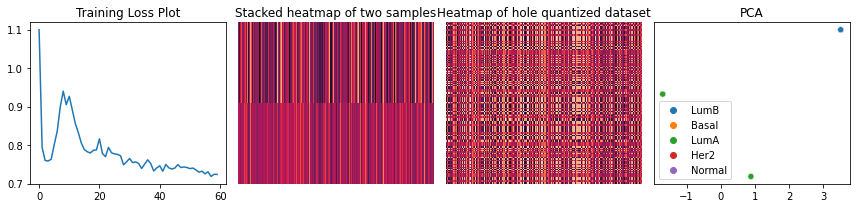

  0%|          | 10/3000 [00:09<58:17,  1.17s/it]

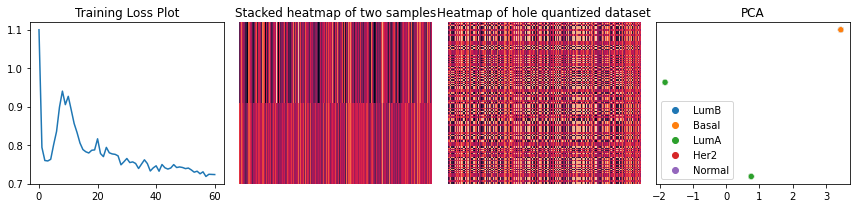

  0%|          | 12/3000 [00:12<58:14,  1.17s/it]  

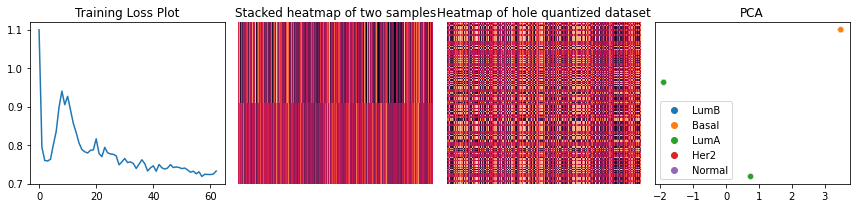

  0%|          | 14/3000 [00:14<1:00:03,  1.21s/it]

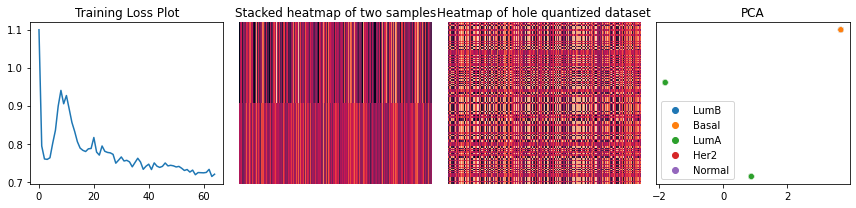

  1%|          | 16/3000 [00:17<58:41,  1.18s/it]  

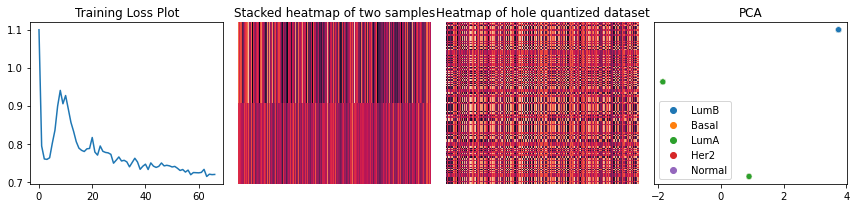

  1%|          | 19/3000 [00:20<54:03,  1.09s/it]  

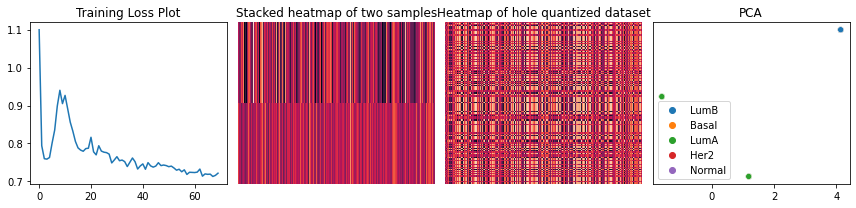

  1%|          | 22/3000 [00:24<51:47,  1.04s/it]  

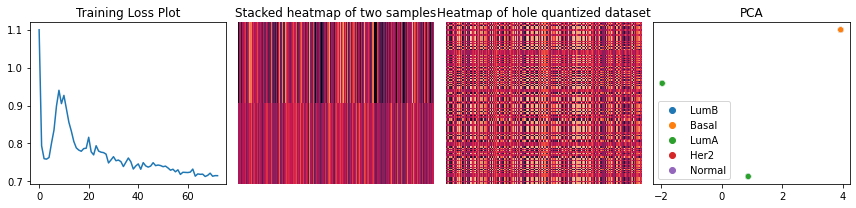

  1%|          | 25/3000 [00:27<51:43,  1.04s/it]

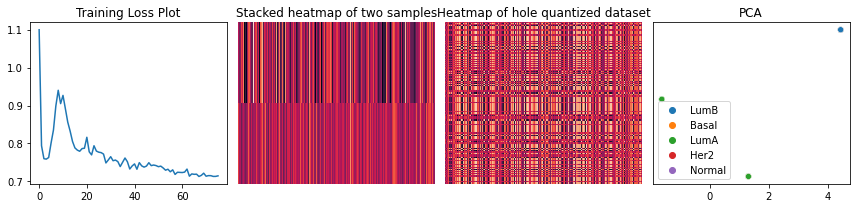

  1%|          | 29/3000 [00:31<49:47,  1.01s/it]  

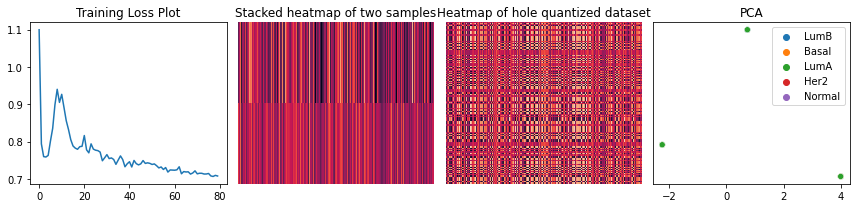

  1%|          | 34/3000 [00:36<47:09,  1.05it/s]

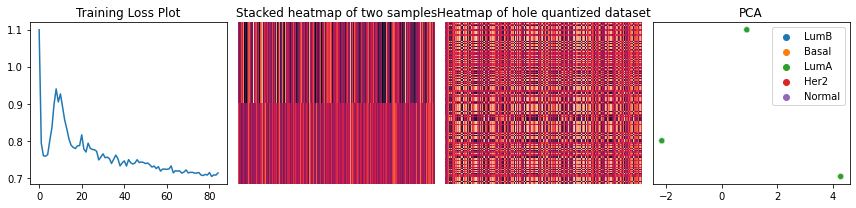

  1%|▏         | 39/3000 [00:41<45:55,  1.07it/s]

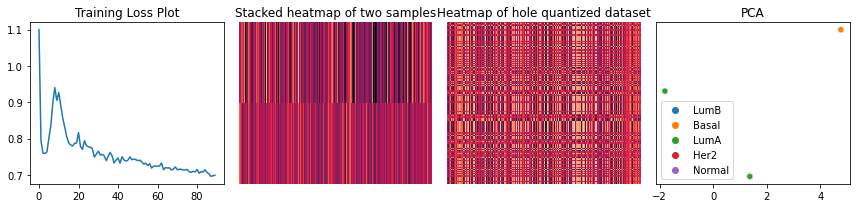

  2%|▏         | 46/3000 [00:48<43:46,  1.12it/s]

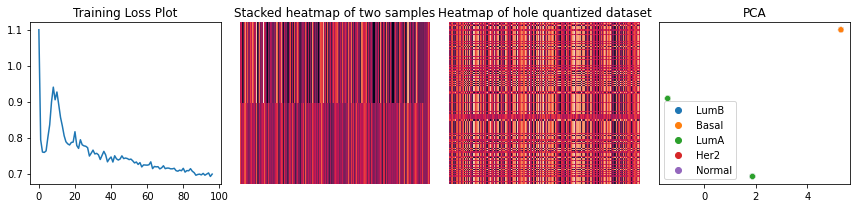

  2%|▏         | 53/3000 [00:55<43:36,  1.13it/s]

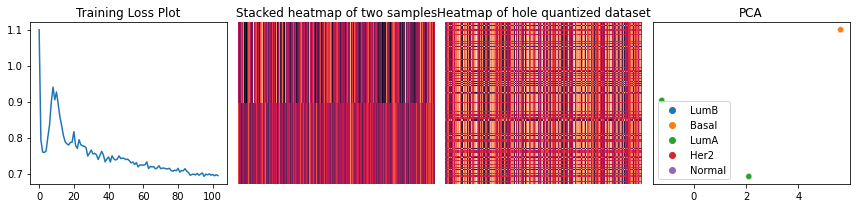

  2%|▏         | 61/3000 [01:03<43:42,  1.12it/s]

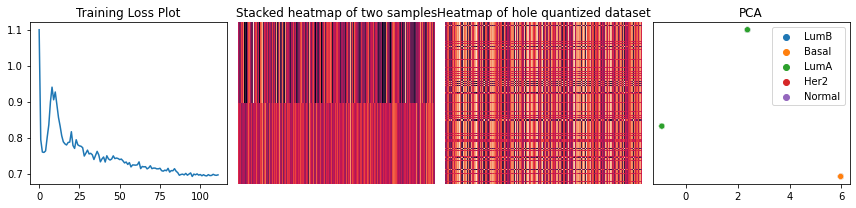

  2%|▏         | 70/3000 [01:11<42:33,  1.15it/s]

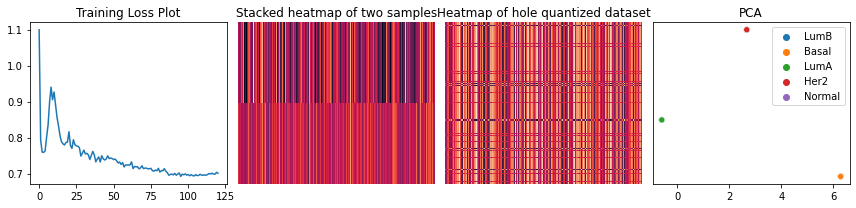

  3%|▎         | 81/3000 [01:22<41:59,  1.16it/s]

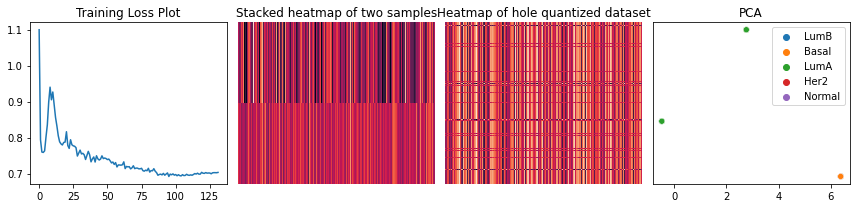

  3%|▎         | 94/3000 [01:34<41:44,  1.16it/s]

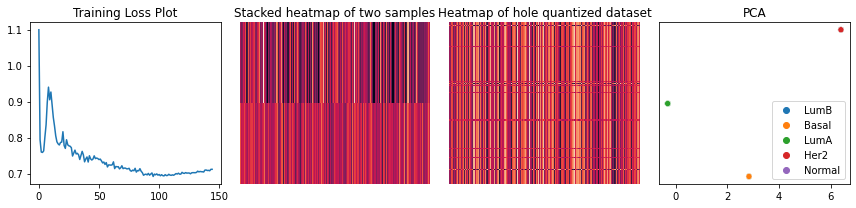

  4%|▎         | 108/3000 [01:47<45:08,  1.07it/s]

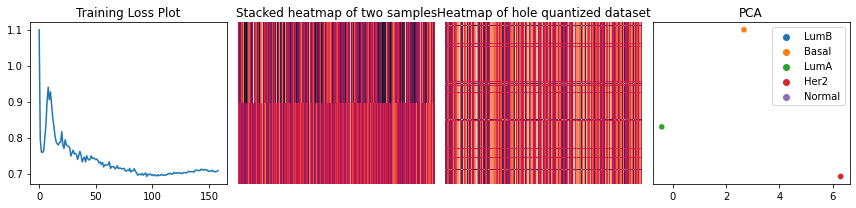

  4%|▍         | 125/3000 [02:03<41:00,  1.17it/s]

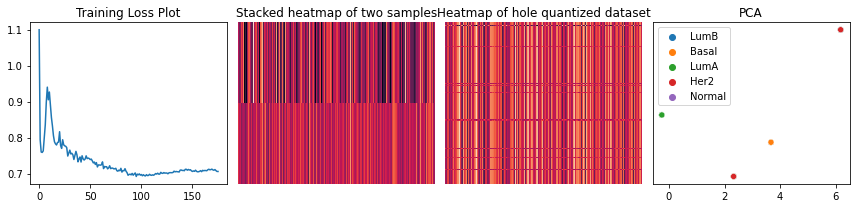

  5%|▍         | 144/3000 [02:20<40:29,  1.18it/s]

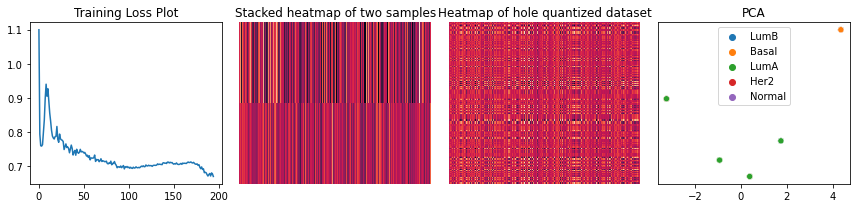

  6%|▌         | 166/3000 [02:39<40:17,  1.17it/s]

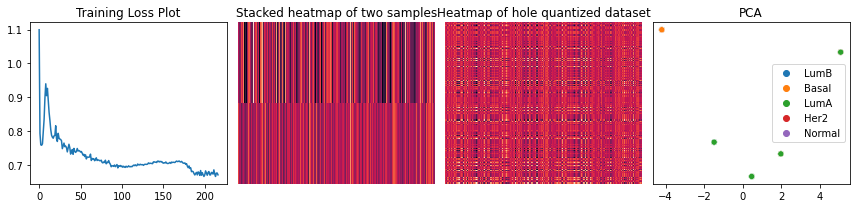

  6%|▋         | 192/3000 [03:03<39:50,  1.17it/s]

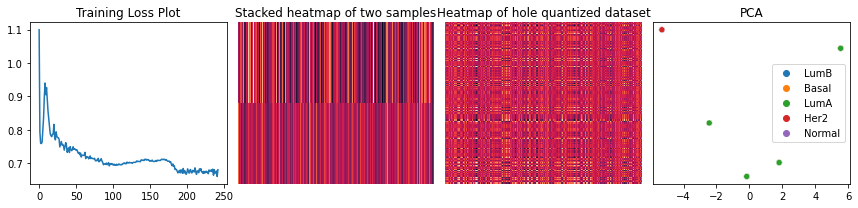

  7%|▋         | 221/3000 [03:28<39:27,  1.17it/s]

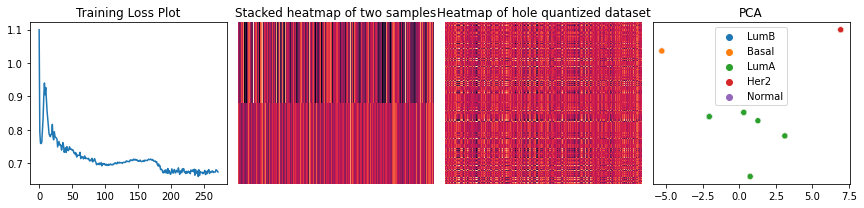

  8%|▊         | 254/3000 [03:57<38:54,  1.18it/s]

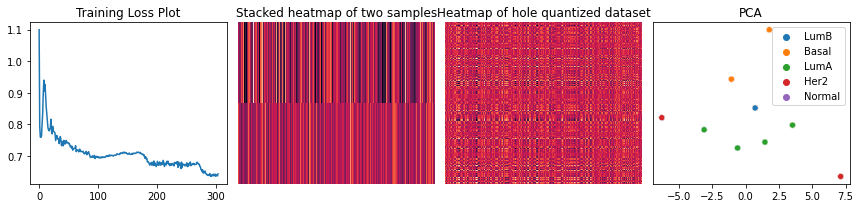

 10%|▉         | 293/3000 [04:32<38:37,  1.17it/s]

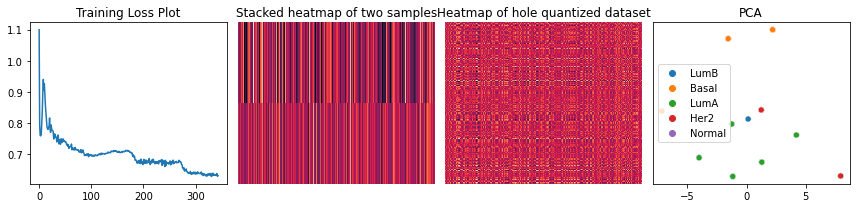

 11%|█▏        | 338/3000 [05:11<38:20,  1.16it/s]

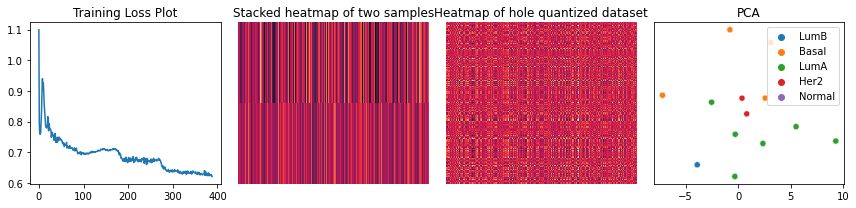

 13%|█▎        | 389/3000 [05:56<37:26,  1.16it/s]

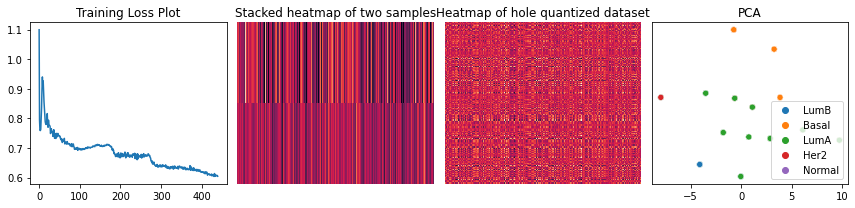

 15%|█▍        | 448/3000 [06:47<36:23,  1.17it/s]

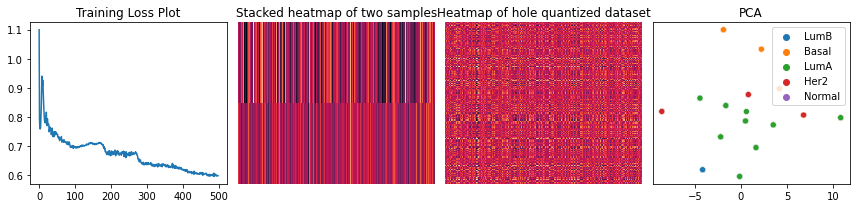

 17%|█▋        | 516/3000 [07:46<35:20,  1.17it/s]

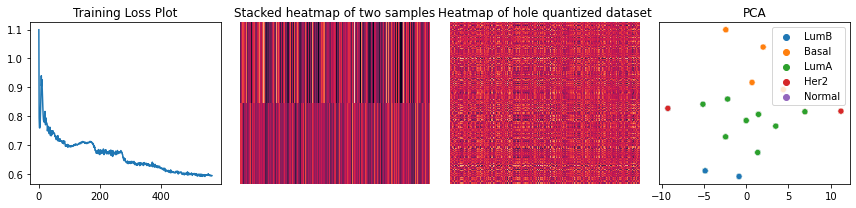

 20%|█▉        | 595/3000 [08:55<34:08,  1.17it/s]

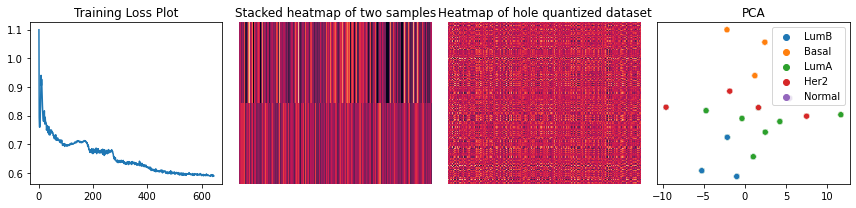

 23%|██▎       | 685/3000 [10:13<32:50,  1.17it/s]

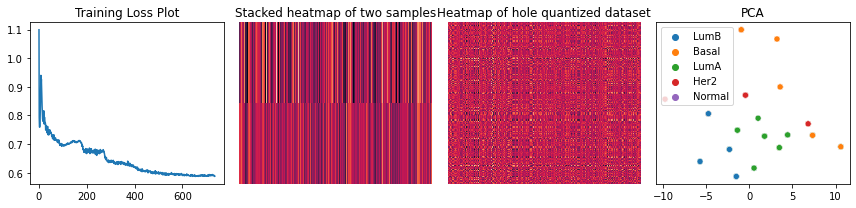

 26%|██▋       | 789/3000 [11:50<41:07,  1.12s/it]

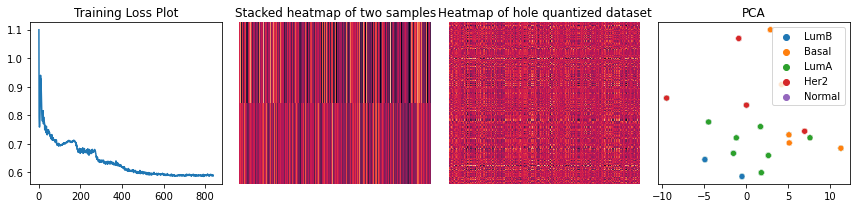

 30%|███       | 909/3000 [13:35<29:17,  1.19it/s]

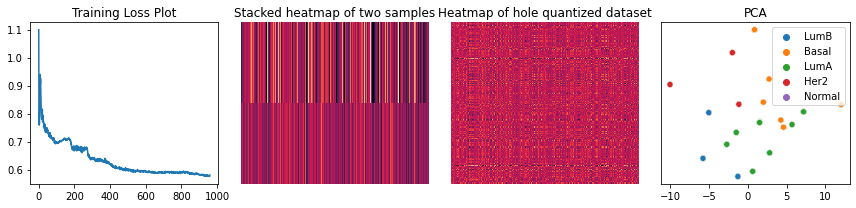

 35%|███▍      | 1047/3000 [15:32<27:01,  1.20it/s]

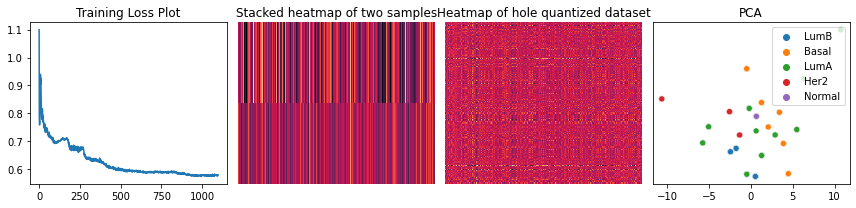

 40%|████      | 1205/3000 [17:47<24:53,  1.20it/s]

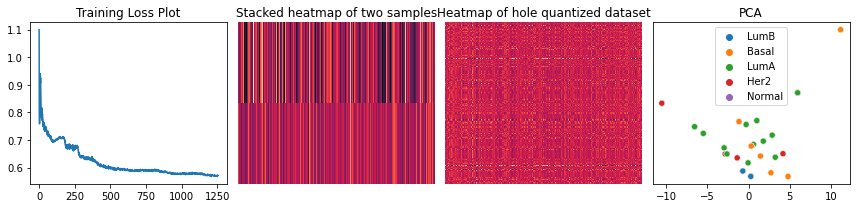

 46%|████▋     | 1388/3000 [20:19<22:26,  1.20it/s]

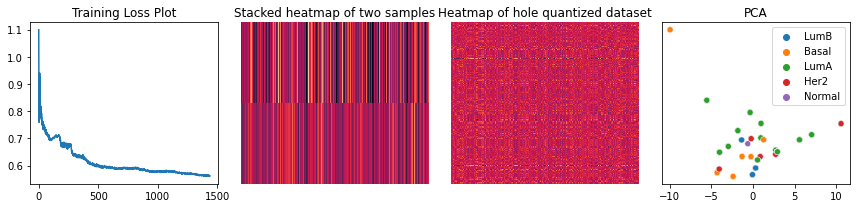

 53%|█████▎    | 1598/3000 [23:15<19:25,  1.20it/s]

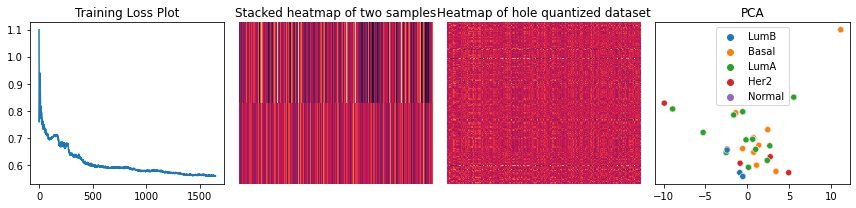

 61%|██████▏   | 1841/3000 [26:46<19:53,  1.03s/it]

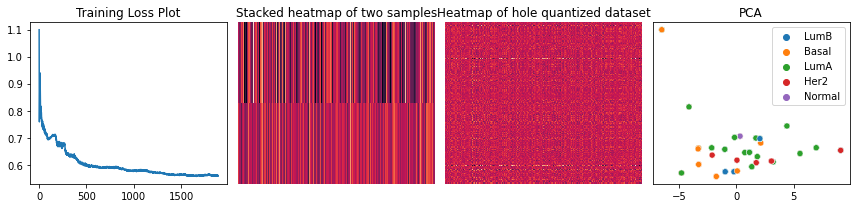

 71%|███████   | 2119/3000 [30:38<12:10,  1.21it/s]

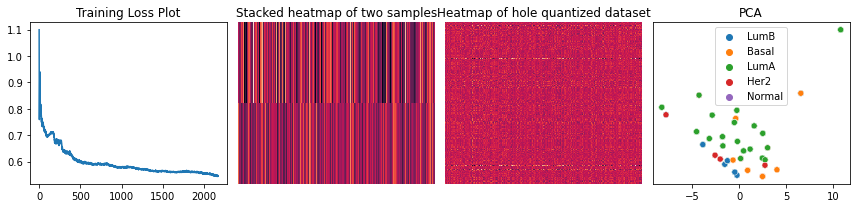

 73%|███████▎  | 2180/3000 [31:32<11:58,  1.14it/s]

In [16]:
EPOCH = 3000

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', min_lr= 1e-5)
print(optimizer.param_groups[0]['lr'])

model.train()

for epoch in tqdm(range(EPOCH)):
    running_loss = 0.0
    count = 0
    
    if model.variational == "VQ-VAE":
        quantized_merge = torch.empty(0,1,64).to(DEVICE)


    # Training loop
    for _, inputs in enumerate(dataloader):
        optimizer.zero_grad()
        inputs = inputs.to(DEVICE)
        # Compute the VAE loss or standard loss
        if model.variational == "VAE":
            outputs, mu, log_var = model(inputs)
            reconstruction_loss = F.mse_loss(outputs, inputs)
            kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            loss = reconstruction_loss + (1 * kld)

        elif model.variational == "VQ-VAE":
            vq_loss, data_recon, perplexity, encodings, quantized = model(inputs)
            recon_error = F.mse_loss(data_recon, inputs) / data_variance
            loss = recon_error + vq_loss

        else:
            outputs = model(inputs)
            loss = F.mse_loss(outputs, inputs)
        
        loss.backward()
        optimizer.step()
        count += 1
        running_loss += loss.item()
    
    # Calculate and store training loss for this epoch
    train_loss = running_loss / count
    monitor.append_loss(train_loss)
    callbacks(epoch)


print(optimizer.param_groups[0]['lr'])
#RuntimeError: The size of tensor a (9189) must match the size of tensor b (9135) at non-singleton dimension 2
